# Detection Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/assignment/ch4_training_images.zip

Archive:  /content/drive/MyDrive/assignment/ch4_training_images.zip
  inflating: ch4_training_images/img_1.jpg  
  inflating: ch4_training_images/img_10.jpg  
  inflating: ch4_training_images/img_100.jpg  
  inflating: ch4_training_images/img_1000.jpg  
  inflating: ch4_training_images/img_101.jpg  
  inflating: ch4_training_images/img_102.jpg  
  inflating: ch4_training_images/img_103.jpg  
  inflating: ch4_training_images/img_104.jpg  
  inflating: ch4_training_images/img_105.jpg  
  inflating: ch4_training_images/img_106.jpg  
  inflating: ch4_training_images/img_107.jpg  
  inflating: ch4_training_images/img_108.jpg  
  inflating: ch4_training_images/img_109.jpg  
  inflating: ch4_training_images/img_11.jpg  
  inflating: ch4_training_images/img_110.jpg  
  inflating: ch4_training_images/img_111.jpg  
  inflating: ch4_training_images/img_112.jpg  
  inflating: ch4_training_images/img_113.jpg  
  inflating: ch4_training_images/img_114.jpg  
  inflating: ch4_training_images/img_115.j

In [ ]:
!unzip /content/drive/MyDrive/assignment/ch4_training_localization_transcription_gt.zip

Archive:  /content/drive/MyDrive/assignment/ch4_training_localization_transcription_gt.zip
  inflating: ch4_training_localization_transcription_gt/gt_img_1.txt  
  inflating: ch4_training_localization_transcription_gt/gt_img_10.txt  
  inflating: ch4_training_localization_transcription_gt/gt_img_100.txt  
  inflating: ch4_training_localization_transcription_gt/gt_img_1000.txt  
  inflating: ch4_training_localization_transcription_gt/gt_img_101.txt  
  inflating: ch4_training_localization_transcription_gt/gt_img_102.txt  
  inflating: ch4_training_localization_transcription_gt/gt_img_103.txt  
  inflating: ch4_training_localization_transcription_gt/gt_img_104.txt  
  inflating: ch4_training_localization_transcription_gt/gt_img_105.txt  
  inflating: ch4_training_localization_transcription_gt/gt_img_106.txt  
  inflating: ch4_training_localization_transcription_gt/gt_img_107.txt  
  inflating: ch4_training_localization_transcription_gt/gt_img_108.txt  
  inflating: ch4_training_localizat

In [ ]:
!unzip /content/drive/MyDrive/assignment/SampleSynth.zip

Streaming output truncated to the last 5000 lines.
  inflating: SampleSynth/195/window_22_88.jpg  
  inflating: SampleSynth/195/window_23_1.jpg  
  inflating: SampleSynth/195/window_26_10.jpg  
  inflating: SampleSynth/195/window_31_40.jpg  
  inflating: SampleSynth/195/window_32_12.jpg  
  inflating: SampleSynth/195/window_34_42.jpg  
  inflating: SampleSynth/195/window_34_43.jpg  
  inflating: SampleSynth/195/window_35_12.jpg  
  inflating: SampleSynth/195/window_35_72.jpg  
  inflating: SampleSynth/195/window_35_78.jpg  
  inflating: SampleSynth/195/window_36_71.jpg  
  inflating: SampleSynth/195/window_36_89.jpg  
  inflating: SampleSynth/195/window_37_29.jpg  
  inflating: SampleSynth/195/window_38_11.jpg  
  inflating: SampleSynth/195/window_38_68.jpg  
  inflating: SampleSynth/195/window_39_104.jpg  
  inflating: SampleSynth/195/window_39_87.jpg  
  inflating: SampleSynth/195/window_39_88.jpg  
  inflating: SampleSynth/195/window_42_96.jpg  
  inflating: SampleSynth/195/window_5

In [ ]:
# Imports
import numpy as np
import os
import scipy.io
import glob
from tqdm import tqdm 
import random
import pickle
import cv2
import time
import scipy.optimize
from shapely.geometry import Polygon
import math
import traceback
import warnings
import matplotlib.pyplot as plt
import matplotlib.patches as Patches
from shapely.geometry import Polygon
import tensorflow as tf
from sklearn.model_selection import train_test_split
import math
import pydot
from DataGenerator import DataGenerator
from Detection_Loss import Detection_Loss
from Detection_Pipeline import Detection_Pipeline
try:
    import queue
except ImportError:
    import Queue as queue
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Create custom DConv layer having upsample, conv and bn layers

class Deconv(tf.keras.layers.Layer):
    
    def __init__(self,name="deconv"):
        super().__init__(name)
        self.inp_shape = 0
        self.upsample = None
        self.conv = None
        self.bn = None
        
    def build(self,imshape):
        self.inp_shape=imshape
        self.upsample=tf.keras.layers.UpSampling2D(size=(2,2),interpolation='bilinear',data_format='channels_last',)
        self.conv=tf.keras.layers.Conv2D(filters=self.inp_shape[-1]//2,kernel_size=3,padding='same',activation='relu',
                                         kernel_initializer=tf.keras.initializers.GlorotNormal(seed=12),
                                         kernel_regularizer=tf.keras.regularizers.l2(1e-5), use_bias=False)
        self.bn=tf.keras.layers.BatchNormalization()
   
    def call(self,X):
    
        x=self.upsample(X)
        x=self.conv(x)
        x=self.bn(x)
        return x

In [ ]:
# Text Detection Model with pretrained ResNet50 and Deconv layer

# Shared network 
# ----start---
resnet=tf.keras.applications.ResNet50(input_shape=(512,512,3),include_top=False,weights='imagenet')
tf.keras.backend.clear_session()

x = resnet.get_layer('conv5_block3_out').output

x = Deconv('Deconv1')(x)
x = tf.keras.layers.add([x,resnet.get_layer('conv4_block6_out').output])

x = Deconv('Deconv2')(x)
x = tf.keras.layers.add([x,resnet.get_layer('conv3_block4_out').output])

x = Deconv('Deconv3')(x)
x = tf.keras.layers.add([x,resnet.get_layer('conv2_block3_out').output])

# --- end ---

# text detector specific
x = Deconv('Deconv4')(x)
x = Deconv('Deconv5')(x)

score=tf.keras.layers.Conv2D(1,kernel_size=3,padding='same',activation='sigmoid')(x)

# Used this beacause sigmoid gives values in range of 0-1(as mentioned in git repository)
geo_map=tf.keras.layers.Conv2D(4,kernel_size=3,padding='same',activation='sigmoid')(x)*512

# Angles are assumed to be between [-45 to 45]
angle_map=(tf.keras.layers.Conv2D(1,kernel_size=3,padding='same',activation='sigmoid')(x)-0.5)*np.pi/2

out=tf.concat([score,geo_map,angle_map],axis=3)

detector=tf.keras.Model(resnet.input,out,name='detector')

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
detector.summary()

Model: "detector"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

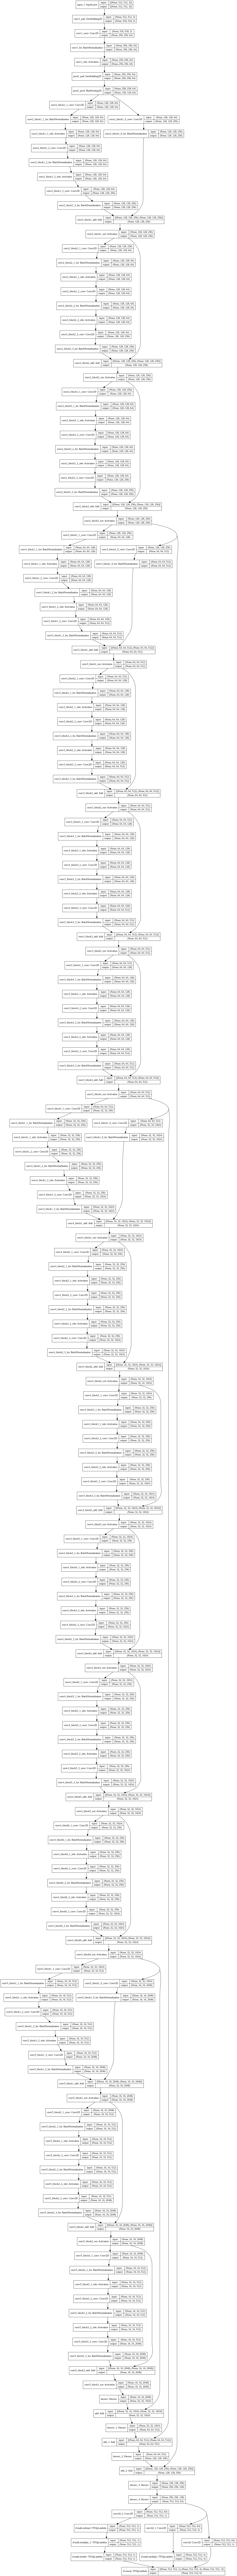

In [ ]:
tf.keras.utils.plot_model(detector,show_shapes=True)

### Train with Synth data

In [ ]:
#tensorboard=tf.keras.callbacks.TensorBoard(log_dir='detection_synth',write_images=True,histogram_freq=1)
#roplateau=tf.keras.callbacks.ReduceLROnPlateau(monitor='loss',factor=0.90,patience=2,mode='min')
# early=tf.keras.callbacks.EarlyStopping(monitor='loss',patience=5,mode='min',verbose=1)
# modelchk=tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/assignment/detector_synth.h5',
#                                             save_best_only=True,mode='min',monitor='loss')

In [ ]:
detector.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005,amsgrad=True),loss=Detection_Loss())

In [ ]:
history_=detector.fit(DataGenerator().generate(batch_size=3),steps_per_epoch=100,epochs= 50)
                      # callbacks=[tensorboard])

Epoch 1/50
100/100 [==============================] - 391s 3s/step - loss: 9.4704
Epoch 2/50
100/100 [==============================] - 367s 4s/step - loss: 4.9945
Epoch 3/50
100/100 [==============================] - 372s 4s/step - loss: 4.9271
Epoch 4/50
100/100 [==============================] - 355s 4s/step - loss: 4.5532
Epoch 5/50
100/100 [==============================] - 367s 4s/step - loss: 4.3392
Epoch 6/50
100/100 [==============================] - 351s 4s/step - loss: 3.9060
Epoch 7/50
100/100 [==============================] - 378s 4s/step - loss: 4.1497
Epoch 8/50
100/100 [==============================] - 365s 4s/step - loss: 4.1202
Epoch 9/50
100/100 [==============================] - 361s 4s/step - loss: 3.8080
Epoch 10/50
100/100 [==============================] - 385s 4s/step - loss: 3.7414
Epoch 11/50
100/100 [==============================] - 373s 4s/step - loss: 3.5088
Epoch 12/50
100/100 [==============================] - 376s 4s/step - loss: 3.2768
Epoch 13/50
1

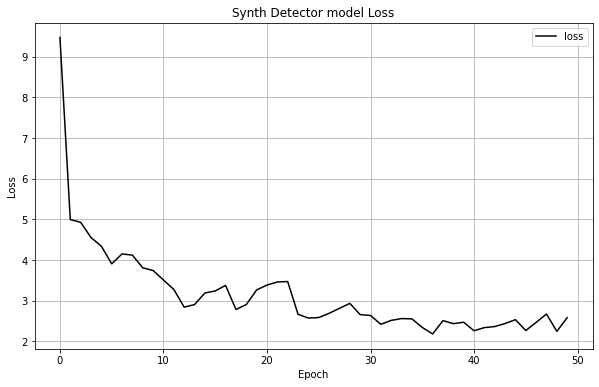

In [ ]:
# Plot epoch-loss for detector model

plt.figure(figsize=(10,6))
plt.plot(history_.history['loss'],color='black')
plt.title('Synth Detector model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss'], loc='upper right')
plt.grid()
plt.savefig('synth_detector_loss.png', dpi=480, bbox_inches='tight')
plt.show()

In [ ]:
# Save weights giving minimum loss
detector.save_weights('/content/drive/MyDrive/assignment/detector_synth.h5')

In [ ]:
# load weight
detector.load_weights('/content/drive/MyDrive/assignment/detector_synth.h5')

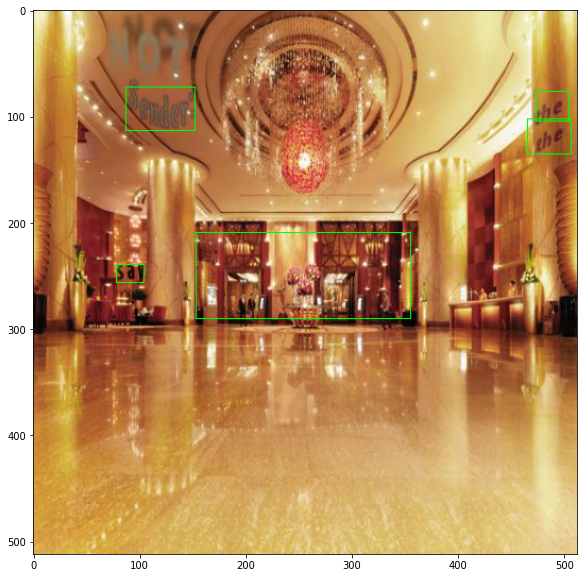

In [ ]:
# Generate bounding box for a synth image
pipeline = Detection_Pipeline()
file = 'SampleSynth/105/lobby+hotel_112_4.jpg'
img=cv2.imread(file)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
im=pipeline.detect(img, detector)
plt.figure(figsize=(10,10))
plt.imshow(im)

### Train with CIDAR data

In [ ]:
# load synth weight before training on CIDAR data
detector.load_weights('/content/drive/MyDrive/assignment/detector_synth.h5')

In [ ]:
detector.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005,amsgrad=True),loss=Detection_Loss())

In [ ]:
history_=detector.fit(DataGenerator().generate(batch_size=3, isSynth = False),steps_per_epoch=100,epochs= 50)

Epoch 1/50
100/100 [==============================] - 196s 1s/step - loss: 1.0592
Epoch 2/50
100/100 [==============================] - 140s 1s/step - loss: 1.0953
Epoch 3/50
100/100 [==============================] - 141s 1s/step - loss: 1.0166
Epoch 4/50
100/100 [==============================] - 151s 2s/step - loss: 0.8673
Epoch 5/50
100/100 [==============================] - 140s 1s/step - loss: 0.8028
Epoch 6/50
100/100 [==============================] - 141s 1s/step - loss: 0.8677
Epoch 7/50
100/100 [==============================] - 147s 1s/step - loss: 0.8276
Epoch 8/50
100/100 [==============================] - 140s 1s/step - loss: 0.6729
Epoch 9/50
100/100 [==============================] - 144s 1s/step - loss: 0.7078
Epoch 10/50
100/100 [==============================] - 148s 1s/step - loss: 0.9332
Epoch 11/50
100/100 [==============================] - 141s 1s/step - loss: 0.7185
Epoch 12/50
100/100 [==============================] - 140s 1s/step - loss: 0.7878
Epoch 13/50
1

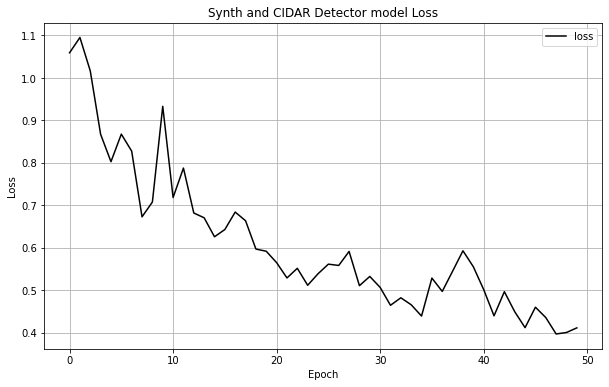

In [ ]:
# Plot epoch-loss for detector model

plt.figure(figsize=(10,6))
plt.plot(history_.history['loss'],color='black')
plt.title('Synth and CIDAR Detector model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss'], loc='upper right')
plt.grid()
plt.savefig('synth_CIDAR_detector_loss.png', dpi=480, bbox_inches='tight')

In [ ]:
# Save weights giving minimum loss
detector.save_weights('/content/drive/MyDrive/assignment/detector_synth_CIDAR.h5')

In [ ]:
# Load weights
detector.load_weights('/content/drive/MyDrive/assignment/detector_synth_CIDAR.h5')

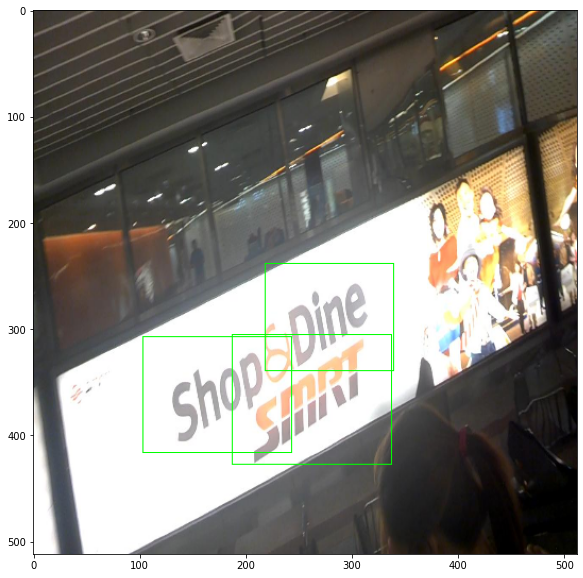

In [ ]:
# Generate bounding box for a CIDAR image
pipeline = Detection_Pipeline()
file = 'ch4_training_images/img_102.jpg'
img=cv2.imread(file)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
im=pipeline.detect(img, detector)
plt.figure(figsize=(10,10))
plt.imshow(im)